<a href="https://colab.research.google.com/github/AlbaCastillo/Movie-Recommendations-Model/blob/main/EDAyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datos y Transformaciones Finales

In [3]:
# Datos
# Se extrae directamente desde un archivo en la carpeta de drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Se cargan los datos a un dataframe
movies_final = pd.read_csv("/content/drive/MyDrive/Modelo de Recomendaciones (Movies)/movies_final.csv")
credits_final = pd.read_csv("/content/drive/MyDrive/Modelo de Recomendaciones (Movies)/credits_final.csv")

In [5]:
movies_final.head(1)

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,return,release_year,collection_name,genres_name,production_companies_names,production_country,spoken_languages_names
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,NaN,Toy Story,7.7,5415.0,12.451801,1995,Toy Story Collection,"Animation, Comedy, Family",Pixar Animation Studios,United States of America,English


In [6]:
credits_final.head(1)

,id,cast_name,director
0,862,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter


In [7]:
final = pd.merge(movies_final, credits_final, on='id', how='left')

In [8]:
final.columns

Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'return', 'release_year',
       'collection_name', 'genres_name', 'production_companies_names',
       'production_country', 'spoken_languages_names', 'cast_name',
       'director'],
      dtype='object')

In [9]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45424 entries, 0 to 45423
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   budget                      45424 non-null  float64
 1   id                          45424 non-null  int64  
 2   original_language           45413 non-null  object 
 3   overview                    44483 non-null  object 
 4   popularity                  45424 non-null  float64
 5   release_date                45424 non-null  object 
 6   revenue                     45424 non-null  float64
 7   runtime                     45178 non-null  float64
 8   status                      45344 non-null  object 
 9   tagline                     20415 non-null  object 
 10  title                       45424 non-null  object 
 11  vote_average                45424 non-null  float64
 12  vote_count                  45424 non-null  float64
 13  return                      454

# EDA (Exploratory Data Analysis)

In [10]:
final.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,return,release_year
count,4.542400e+04,45424.000000,45424.000000,4.542400e+04,45178.000000,45424.000000,45424.000000,4.542400e+04,45424.000000
mean,4.233766e+06,107996.108071,2.927053,1.122594e+07,94.172230,5.623901,110.033903,6.593459e+02,1991.878765
std,1.743430e+07,112135.099435,6.007765,6.435838e+07,38.340319,1.915572,491.492817,7.465382e+04,24.061587
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1874.000000
25%,0.000000e+00,26370.750000,0.389007,0.000000e+00,85.000000,5.000000,3.000000,0.000000e+00,1978.000000
50%,0.000000e+00,59860.500000,1.131130,0.000000e+00,95.000000,6.000000,10.000000,0.000000e+00,2001.000000
75%,0.000000e+00,156357.000000,3.694790,0.000000e+00,107.000000,6.800000,34.000000,0.000000e+00,2010.000000
max,3.800000e+08,469172.000000,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,1.239638e+07,2020.000000


In [11]:
final.describe(include=['O'])

,original_language,overview,release_date,status,tagline,title,collection_name,genres_name,production_companies_names,production_country,spoken_languages_names,cast_name,director
count,45413,44483,45424,45344,20415,45424,4390,43039,33612,39208,41530,43071,44588
unique,89,44232,17333,6,20269,42196,1644,4064,22666,2388,1841,42656,17549
top,en,No overview found.,2008-01-01,Released,Based on a true story.,Cinderella,The Bowery Boys,Drama,Metro-Goldwyn-Mayer (MGM),United States of America,English,Georges Méliès,John Ford
freq,32235,133,136,44984,7,11,29,5004,742,17864,22402,24,66


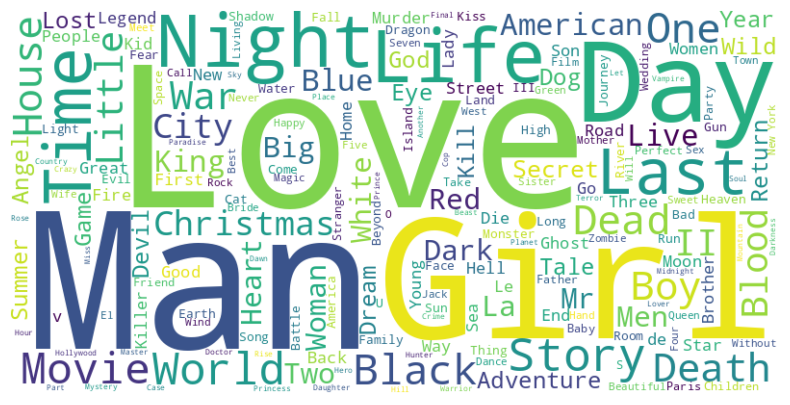

In [12]:
# Nube de palabras title
from wordcloud import WordCloud

titles = final['title']
text = ' '.join(title for title in titles)
# Creación de una nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Visualización de la nube de palabras
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

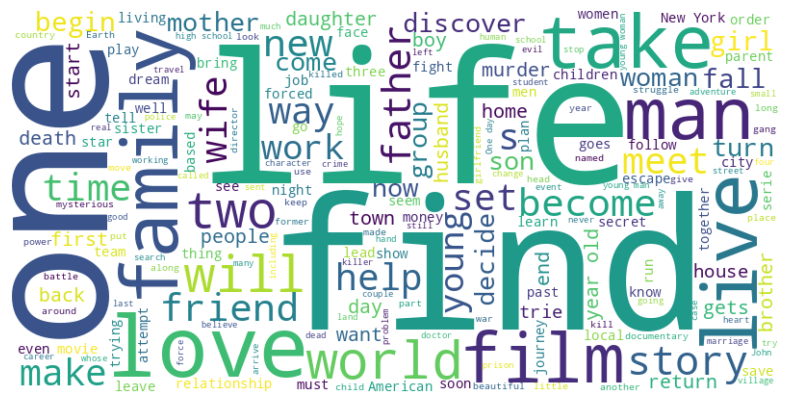

In [13]:
# Nube de palabras overview
from wordcloud import WordCloud

titles = final['overview'].dropna()
text = ' '.join(title for title in titles)
# Creación de una nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Visualización de la nube de palabras
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

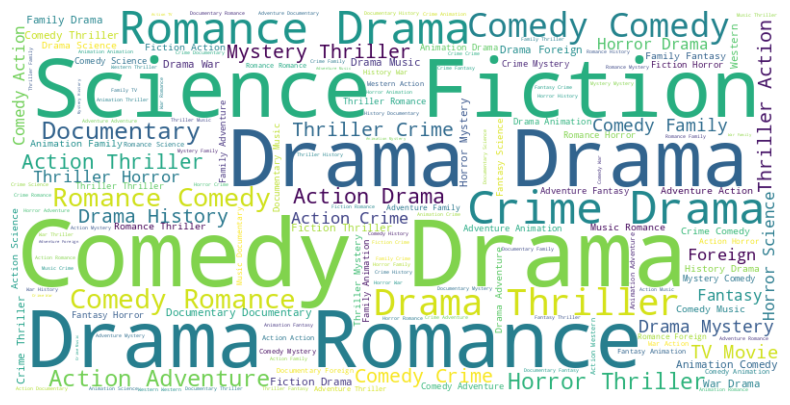

In [14]:
# Nube de palabras genres
from wordcloud import WordCloud

titles = final['genres_name'].dropna()
text = ' '.join(title for title in titles)
# Creación de una nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Visualización de la nube de palabras
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
# Separamos
generos = movies_final['genres_name'].str.split(', ')

# Crearmos una nueva columna duplicada para cada genero
generos = generos.explode('genre').dropna().reset_index(drop=True)
generos

0        Animation
1           Comedy
2           Family
3        Adventure
4          Fantasy
           ...    
90999      Romance
91000        Drama
91001       Action
91002        Drama
91003     Thriller
Name: genres_name, Length: 91004, dtype: object

In [16]:
# Generos
generos.unique()

array(['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music',
       'Documentary', 'Western', 'TV Movie'], dtype=object)

In [17]:
# Cantidad de peliculas por genero
conteo_generos = generos.value_counts()
conteo_generos

Drama              20245
Comedy             13179
Thriller            7616
Romance             6732
Action              6590
Horror              4669
Crime               4304
Documentary         3921
Adventure           3493
Science Fiction     3039
Family              2768
Mystery             2462
Fantasy             2311
Animation           1930
Foreign             1619
Music               1598
History             1397
War                 1323
Western             1042
TV Movie             766
Name: genres_name, dtype: int64

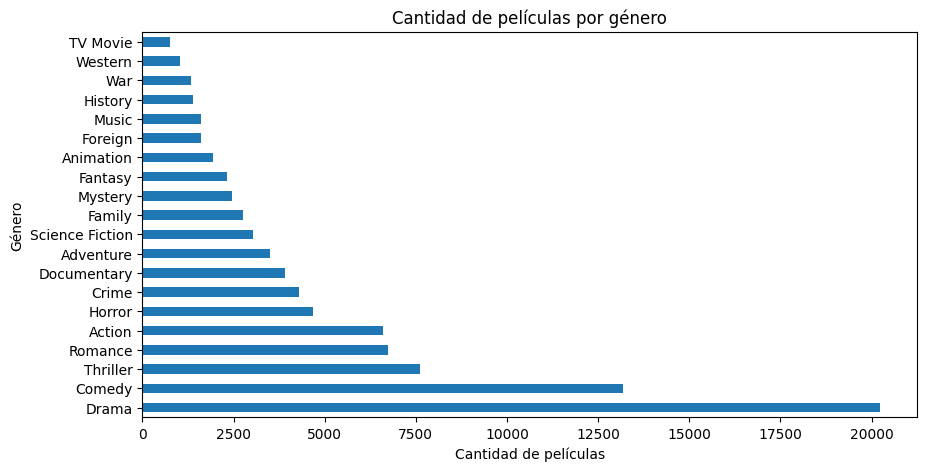

In [18]:
plt.figure(figsize=(10,5))
conteo_generos.plot(kind='barh')  # Creamos un grafico de barras horizontales
plt.title('Cantidad de películas por género')
plt.xlabel('Cantidad de películas')
plt.ylabel('Género')
plt.show()

In [19]:
final.columns

Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'return', 'release_year',
       'collection_name', 'genres_name', 'production_companies_names',
       'production_country', 'spoken_languages_names', 'cast_name',
       'director'],
      dtype='object')

<ipython-input-20-bee260bed482>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genres_name'] = movies_final['genres_name'].str.split(', ')
<ipython-input-20-bee260bed482>:12: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  promedio_por_genero.plot(kind='barh', sort_columns=True)


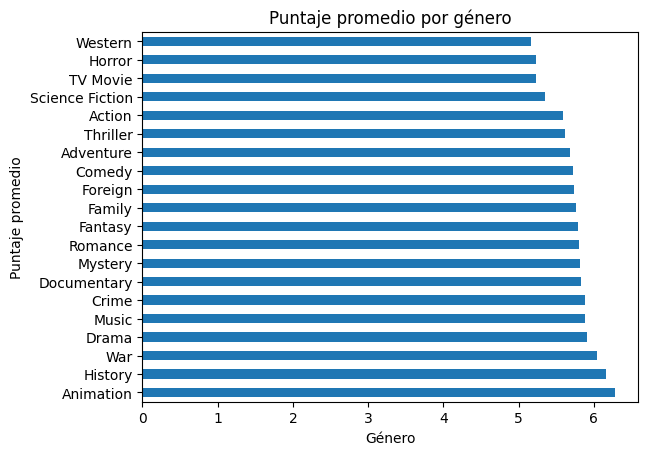

In [20]:
# Separamos
data = movies_final[['genres_name', 'vote_average']]
data['genres_name'] = movies_final['genres_name'].str.split(', ')

# Crearmos una nueva columna duplicada para cada genero
data = data.explode('genres_name').dropna().reset_index(drop=True)

# Calcular el puntaje promedio por género
promedio_por_genero = data.groupby('genres_name')['vote_average'].mean().sort_values(ascending=False)

# Crear un gráfico de barras
promedio_por_genero.plot(kind='barh', sort_columns=True)
# Agregar etiquetas y título
plt.xlabel('Género')
plt.ylabel('Puntaje promedio')
plt.title('Puntaje promedio por género')

# Mostrar el gráfico
plt.show()

Se propone la creacion de dos modelos o un hibrido, de un Knn y un algoritmo de similitud por texto

# Algoritmo de similitud

### Transformacion y limpieza de datos

In [21]:
# Df para algoritmo
# Columnas ['overview', 'tagline', 'title',  'cast_name', 'genres_name', 'director', 'spoken_languages_names']
final_s = final[['overview', 'tagline', 'title', 'cast_name', 'genres_name', 'director', 'spoken_languages_names']]
final_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45424 entries, 0 to 45423
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   overview                44483 non-null  object
 1   tagline                 20415 non-null  object
 2   title                   45424 non-null  object
 3   cast_name               43071 non-null  object
 4   genres_name             43039 non-null  object
 5   director                44588 non-null  object
 6   spoken_languages_names  41530 non-null  object
dtypes: object(7)
memory usage: 2.8+ MB


In [22]:
# Eliminación de filas con valores nulos en la columna 'overview' ya que es en la que mas nos enfocaremos
final_s = final_s.dropna(subset=['overview'])

In [23]:
# Creación de una nueva columna 'description' concatenando 'overview' y 'tagline'
final_s['description'] = final_s['title'] + ' ' + final_s['overview'] + ' ' + final_s['tagline'].fillna('')  + ' ' + final_s['cast_name'].fillna('') + ' ' + final_s['genres_name'].fillna('')+ ' ' + final_s['director'].fillna('')+ ' ' + final_s['spoken_languages_names'].fillna('')


In [24]:
final_s.head(2)

,overview,tagline,title,cast_name,genres_name,director,spoken_languages_names,description
0,"Led by Woody, Andy's toys live happily in his ...",NaN,Toy Story,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...","Animation, Comedy, Family",John Lasseter,English,"Toy Story Led by Woody, Andy's toys live happi..."
1,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","Adventure, Fantasy, Family",Joe Johnston,"English, Français",Jumanji When siblings Judy and Peter discover ...


In [25]:
final_s.iloc[1,7]

"Jumanji When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures. Roll the dice and unleash the excitement! Robin Williams, Jonathan Hyde, Kirsten Dunst, Bradley Pierce, Bonnie Hunt, Bebe Neuwirth, David Alan Grier, Patricia Clarkson, Adam Hann-Byrd, Laura Bell Bundy, James Handy, Gillian Barber, Brandon Obray, Cyrus Thiedeke, Gary Joseph Thorup, Leonard Zola, Lloyd Berry, Malcolm Stewart, Annabel Kershaw, Darryl Henriques, Robyn Driscoll, Peter Bryant, Sarah Gilson, Florica Vlad, June Lion, Brenda Lockmuller Adventure, Fantasy, Family Joe Johnston English, Français"

In [26]:
# Eliminamos las columnas ['overview', 'tagline',  'cast_name']
final_s = final_s.drop(['overview', 'tagline', 'cast_name', 'genres_name', 'director', 'spoken_languages_names'], axis=1)

In [28]:
final_s.columns

Index(['title', 'description'], dtype='object')

In [29]:
# Configuración de la columna 'title' como índice del DataFrame
final_s = final_s.set_index('title')

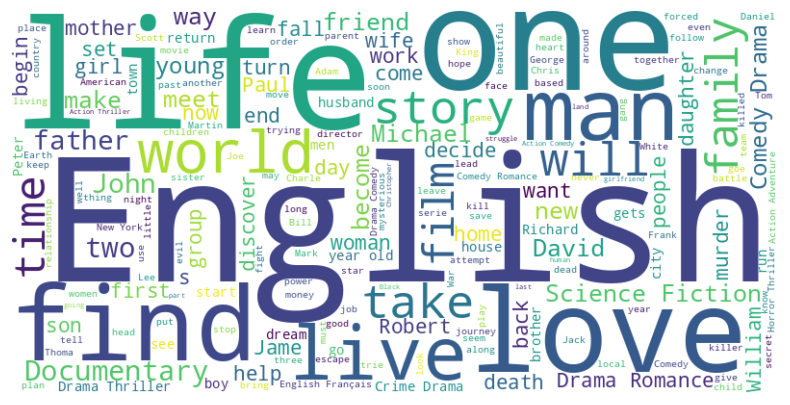

In [30]:
from wordcloud import WordCloud

titles = final_s['description']
text = ' '.join(title for title in titles)
# Creación de una nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Visualización de la nube de palabras
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## ML (Modelo de similitud a travez del texto)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
# El df completo es mucho para procesar con los recursos disponibles
# Probamos con una porcion
final_s2 = final_s.sample(frac=0.4, random_state=1)
# Se probo con diferentes cantidades, y el 40% fue la mayor cantidad sin sobrepasar los limites de los recursos

In [33]:
# Creación de un vectorizador TF-IDF para la columna 'description'
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(final_s2['description'])

In [34]:
# Cálculo de las similitudes entre contenidos
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [35]:
def get_similar_movies(movie_title, top_n=5):
    idx = final_s2.index.get_loc(movie_title)
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_titles = [final_s2.index[i] for i in [i[0] for i in sim_scores]]
    return movie_titles

In [36]:
# Ejemplo de recomendación para la película "The Dark Knight"
recommended_movies = get_similar_movies("The Dark Knight", top_n=5)
print(recommended_movies)

['Batman: The Dark Knight Returns, Part 2', 'Chain Reaction', 'Pearl Harbor', 'Batman Unmasked: The Psychology of the Dark Knight', 'Batman Forever']


In [37]:
# Ejemplo de recomendación para la película "Step Up"
recommended_movies = get_similar_movies("Step Up", top_n=5)
print(recommended_movies)

['Hairspray', 'Hot Pursuit', 'Boys and Girls', 'Magic Mike', 'Scream 2']


In [38]:
# from scipy.sparse import csr_matrix
# Creación de un vectorizador TF-IDF para la columna 'description'
# vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = vectorizer.fit_transform(final_s['description'])

 #Para convertir la matriz densa tfidf_matrix en una matriz dispersa
# tfidf_matrix_sparse = csr_matrix(tfidf_matrix)

In [39]:
# Cálculo de las similitudes entre contenidos
# similarity_matrix_sparse = cosine_similarity(tfidf_matrix_sparse, tfidf_matrix_sparse)

# Nearest Neighbors (Texto, "menor consumo de RAM")

In [40]:
final.columns

Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'return', 'release_year',
       'collection_name', 'genres_name', 'production_companies_names',
       'production_country', 'spoken_languages_names', 'cast_name',
       'director'],
      dtype='object')

In [147]:
# Df para algoritmo
# Columnas ['overview', 'tagline', 'title',  'cast_name', 'genres_name', 'director', 'spoken_languages_names']
final_nn = final[['overview', 'tagline', 'title', 'genres_name', 'director', 'spoken_languages_names', 'cast_name']]
final_nn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45424 entries, 0 to 45423
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   overview                44483 non-null  object
 1   tagline                 20415 non-null  object
 2   title                   45424 non-null  object
 3   genres_name             43039 non-null  object
 4   director                44588 non-null  object
 5   spoken_languages_names  41530 non-null  object
 6   cast_name               43071 non-null  object
dtypes: object(7)
memory usage: 2.8+ MB


In [148]:
# Eliminación de filas con valores nulos en la columna 'overview' ya que es en la que mas nos enfocaremos
final_nn = final_nn.dropna(subset=['overview']).reset_index()

In [149]:
# Creación de una nueva columna 'description' concatenando 'overview' y 'tagline'
final_nn['description'] = final_nn['title'] + ' ' + final_nn['overview'] + ' ' + final_nn['tagline'].fillna('')   + ' ' + final_nn['genres_name'].fillna('')+ ' ' + final_nn['director'].fillna('')+ ' ' + final_nn['cast_name'].fillna('')


In [150]:
# Eliminamos las columnas ['overview', 'tagline', 'genres_name', 'director', 'spoken_languages_names', 'cast_name']
final_nn = final_nn.drop(['overview', 'tagline', 'genres_name', 'director', 'spoken_languages_names', 'cast_name'], axis=1)

In [151]:
final_nn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44483 entries, 0 to 44482
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        44483 non-null  int64 
 1   title        44483 non-null  object
 2   description  44483 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

In [153]:
# Creación de un vectorizador TF-IDF para la columna 'description'
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(final_nn['description'])

In [154]:
# Creamos un modelo para encontrar los vecinos mas cercanos
nn = NearestNeighbors(metric='cosine', algorithm='auto')
nn.fit(tfidf_matrix)

NearestNeighbors(metric='cosine')

In [155]:
movie_index = final_nn[final_nn['title'] == 'Toy Story'].index[0]
neighbors = nn.kneighbors(tfidf_matrix[movie_index], n_neighbors=6)
neighbors

(array([[0.        , 0.490544  , 0.63747116, 0.75757546, 0.80612109,
         0.81582273]]),
 array([[    0,  2980, 15296, 24317, 21769,  1186]]))

In [156]:

# Obtener los índices de las películas más similares
indices = neighbors[1][0]

# Obtener los títulos de las películas más similares
similar_movie_titles = final_nn.iloc[indices]['title']

# Imprimir los títulos de las películas más similares
print(similar_movie_titles)


0                   Toy Story
2980              Toy Story 2
15296             Toy Story 3
24317               Small Fry
21769    Toy Story of Terror!
1186                Manhattan
Name: title, dtype: object


In [157]:
movie_index = final_nn[final_nn['title'] == 'The Dark Knight'].index[0]
neighbors = nn.kneighbors(tfidf_matrix[movie_index], n_neighbors=6)
# Obtener los índices de las películas más similares
indices = neighbors[1][0]

# Obtener los títulos de las películas más similares
similar_movie_titles = final_nn.iloc[indices]['title']

# Imprimir los títulos de las películas más similares
print(similar_movie_titles)

12456                            The Dark Knight
18157                      The Dark Knight Rises
10097                              Batman Begins
20102    Batman: The Dark Knight Returns, Part 2
19672    Batman: The Dark Knight Returns, Part 1
583                                       Batman
Name: title, dtype: object


In [158]:
movie_index = final_nn[final_nn['title'] == 'Twilight'].index[0]
neighbors = nn.kneighbors(tfidf_matrix[movie_index])
# Obtener los índices de las películas más similares
indices = neighbors[1][0]

# Obtener los títulos de las películas más similares
similar_movie_titles = final_nn.iloc[indices]['title']

# Imprimir los títulos de las películas más similares
print(similar_movie_titles)

1677                Twilight
8930           Narrow Margin
4776     The Cheap Detective
8728             Night Moves
29085        Without a Trace
Name: title, dtype: object


In [159]:
 # Probar con CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
cv = vectorizer.fit_transform(final_nn['description'])

In [160]:
# Creamos un modelo para encontrar los vecinos mas cercanos
nn_cv = NearestNeighbors(metric='cosine', algorithm='auto')
nn_cv.fit(cv)

NearestNeighbors(metric='cosine')

In [161]:
movie_index = final_nn[final_nn['title'] == 'Toy Story'].index[0]
neighbors = nn_cv.kneighbors(cv[movie_index])
neighbors

(array([[1.11022302e-15, 4.21555227e-01, 5.42612816e-01, 6.36196562e-01,
         6.57002830e-01]]),
 array([[    0,  2980, 15296, 37778,  4262]]))

In [162]:
# Obtener los índices de las películas más similares
indices = neighbors[1][0]

# Obtener los títulos de las películas más similares
similar_movie_titles = final_nn.iloc[indices]['title']

# Imprimir los títulos de las películas más similares
print(similar_movie_titles)


0              Toy Story
2980         Toy Story 2
15296        Toy Story 3
37778              Sleep
4262     Shadows and Fog
Name: title, dtype: object


In [163]:
movie_index = final_nn[final_nn['title'] == 'The Dark Knight'].index[0]
neighbors = nn_cv.kneighbors(cv[movie_index])
# Obtener los índices de las películas más similares
indices = neighbors[1][0]

# Obtener los títulos de las películas más similares
similar_movie_titles = final_nn.iloc[indices]['title']

# Imprimir los títulos de las películas más similares
print(similar_movie_titles)

12456          The Dark Knight
18157    The Dark Knight Rises
4163              Pearl Harbor
3863               Wall Street
2104                  Rounders
Name: title, dtype: object


In [164]:
movie_index = final_nn[final_nn['title'] == 'Twilight'].index[0]
neighbors = nn_cv.kneighbors(cv[movie_index])
# Obtener los índices de las películas más similares
indices = neighbors[1][0]

# Obtener los títulos de las películas más similares
similar_movie_titles = final_nn.iloc[indices]['title']

# Imprimir los títulos de las películas más similares
print(similar_movie_titles)

1677                  Twilight
17122                   Stolen
2922                    Oxygen
31756               Uncle John
9876     Electra Glide in Blue
Name: title, dtype: object


Analizando los resultados, obtenemos peliculas mas proximas y de manera mas eficaz con el modelo de NearestNeighbors y datos con TfidfVectorizer, modelo final (nn)


**Funcion para la ejecucion del modelo**

In [165]:
def recomendacion(title):
  title = title.replace(" ", "").lower()
  movie_index = final_nn[final_nn['title'].str.replace(" ", "").str.lower().str == title].index[0]
  neighbors = nn.kneighbors(tfidf_matrix[movie_index], n_neighbors=6)
  # Obtener los índices de las películas más similares
  indices = neighbors[1][0]

  # Obtener los títulos de las películas más similares
  similar_movie_titles = final_nn.iloc[indices]['title']

  return
